In [1]:
using LinearAlgebra
using Random
using Distributions
using KernelDensity
include("../Inversion/Plot.jl")
include("../Inversion/GaussianMixture.jl")
include("../Inversion/GMBBVI.jl")
include("../Inversion/AnnealingInitialize.jl")
include("./MultiModal.jl")


Gaussian_mixture_VI (generic function with 1 method)

In [13]:
function visualization(ax, objs, func_Phi, Gtype::String;
    N_x_array = nothing, Nx = 100, Ny = 100, x_lim = [-3.0, 3.0], y_lim = [-3.0, 3.0], N_iter = 200)
    
    # posterior_mean, posterior_cov = multimodal_moments(Gtype)

    x_min, x_max = x_lim 
    y_min, y_max = y_lim

    xx = LinRange(x_min, x_max, Nx)
    yy = LinRange(y_min, y_max, Ny)
    
    dx, dy = xx[2] - xx[1], yy[2] - yy[1]
    X,Y = repeat(xx, 1, Ny), repeat(yy, 1, Nx)'
    Z_ref = posterior_2d(func_Phi, X, Y, "func_Phi")
    
    color_lim = (minimum(Z_ref), maximum(Z_ref))
    ax[1].pcolormesh(X, Y, Z_ref, cmap="viridis", clim=color_lim)

    N_dims = length(objs)
    N_trials = length(objs[1])
    errors = zeros(N_trials, N_iter+1, N_dims, 1)  # length(objs) represents the number of different dimensions of objs

    for (i_param, obj) in enumerate(objs)  # enumerate by parameters of GMBBVI
        for (i, bbvi_obj) in enumerate(obj) # enumerate by repeated trials of GMBBVI
            for iter = 0:N_iter
                x_w = exp.(bbvi_obj.logx_w[iter+1]); x_w /= sum(x_w)
                x_mean = bbvi_obj.x_mean[iter+1][:,1:2]
                xx_cov = bbvi_obj.xx_cov[iter+1][:,1:2,1:2]
                Z = Gaussian_mixture_2d(x_w, x_mean, xx_cov,  X, Y)

                # ρ_gm_mean, ρ_gm_cov = compute_ρ_gm_moments(x_w, x_mean, xx_cov)

                errors[i, iter+1, i_param, 1] = norm(Z - Z_ref,1)*dx*dy
                # errors[i, iter+1, i_param, 2] = norm(ρ_gm_mean - posterior_mean, 2)
                # errors[i, iter+1, i_param, 3] = norm(ρ_gm_cov - posterior_cov, 2)/norm(posterior_cov, 2)
                
                if i == 1 && iter == N_iter  
                    # plot the outcome of the first trial 
                    ax[i_param + 1].pcolormesh(X, Y, Z, cmap="viridis", clim=color_lim)
                    ax[i_param + 1].scatter([bbvi_obj.x_mean[1][:,1];], [bbvi_obj.x_mean[1][:,2];], marker="x", color="grey", alpha=0.5) 
                    ax[i_param + 1].scatter([x_mean[:,1];], [x_mean[:,2];], marker="o", color="red", facecolors="none", alpha=0.5)

                    ax[i_param + 1].set_xlim(x_lim)
                    ax[i_param + 1].set_ylim(y_lim)
                end
            end
        end
    end

    error_mean = reshape(mean(errors, dims=1), N_iter+1, N_dims, 1)
    error_std = reshape(std(errors, dims=1), N_iter+1, N_dims, 1)


    for i = 1:N_dims

        # ax[end-2].semilogy(Array(0:N_iter), error_mean[:,i,2])
        # ax[end-1].semilogy(Array(0:N_iter), error_mean[:,i,3])


        if N_x_array === nothing
            line = ax[end].semilogy(Array(0:N_iter), error_mean[:,i,1])
        else
            line = ax[end].semilogy(Array(0:N_iter), error_mean[:,i,1], label = "d="*string(N_x_array[i]))    
        end
    
        ax[end].fill_between(Array(0:N_iter), error_mean[:,i,1] - error_std[:,i,1], error_mean[:,i,1] + error_std[:,i,1], color=line[1].get_color(), alpha=0.25)

    end

    if N_x_array !== nothing  ax[end].legend()  end

end

visualization (generic function with 1 method)

[ Info: Running: circle density
[ Info: ("iter = ", 50, " / ", 500)
[ Info: ("iter = ", 100, " / ", 500)
[ Info: ("iter = ", 150, " / ", 500)
[ Info: ("iter = ", 200, " / ", 500)
[ Info: ("iter = ", 250, " / ", 500)
[ Info: ("iter = ", 300, " / ", 500)
[ Info: ("iter = ", 350, " / ", 500)
[ Info: ("iter = ", 400, " / ", 500)
[ Info: ("iter = ", 450, " / ", 500)
[ Info: ("iter = ", 500, " / ", 500)
[ Info: ("iter = ", 50, " / ", 500)
[ Info: ("iter = ", 100, " / ", 500)
[ Info: ("iter = ", 150, " / ", 500)
[ Info: ("iter = ", 200, " / ", 500)
[ Info: ("iter = ", 250, " / ", 500)
[ Info: ("iter = ", 300, " / ", 500)
[ Info: ("iter = ", 350, " / ", 500)
[ Info: ("iter = ", 400, " / ", 500)
[ Info: ("iter = ", 450, " / ", 500)
[ Info: ("iter = ", 500, " / ", 500)
[ Info: ("iter = ", 50, " / ", 500)
[ Info: ("iter = ", 100, " / ", 500)
[ Info: ("iter = ", 150, " / ", 500)
[ Info: ("iter = ", 200, " / ", 500)
[ Info: ("iter = ", 250, " / ", 500)
[ Info: ("iter = ", 300, " / ", 500)
[ Info: (

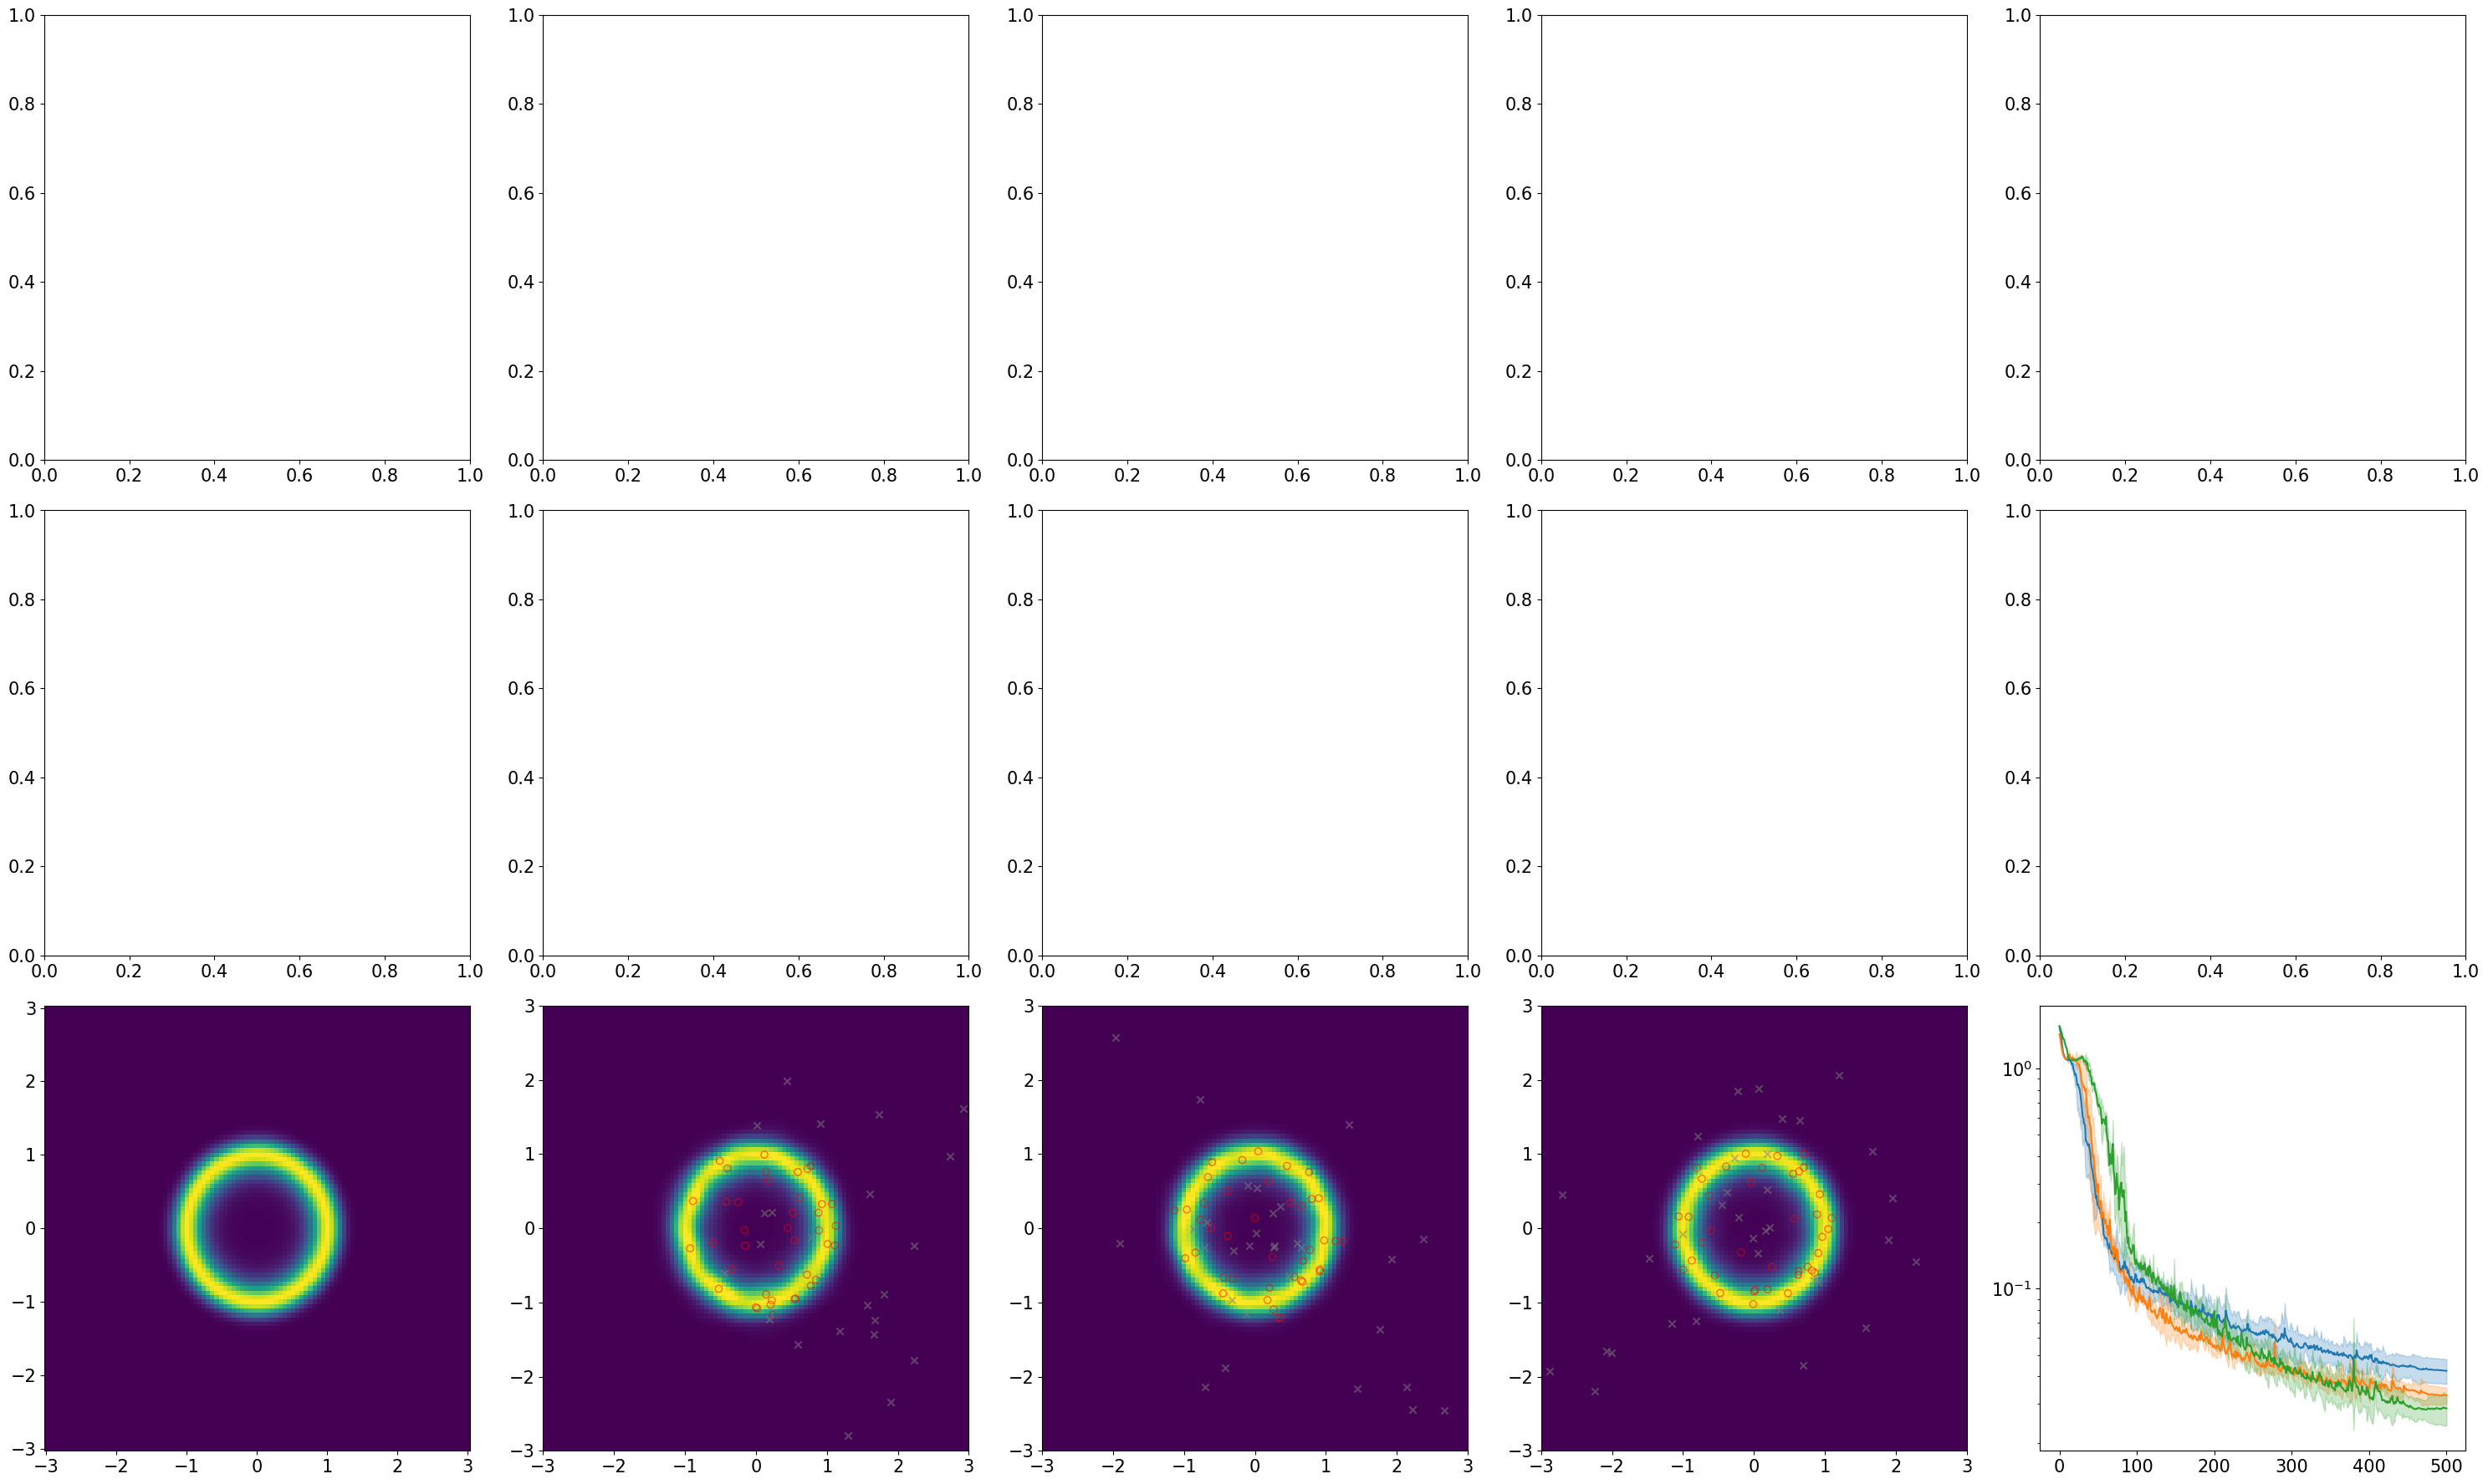

In [ ]:
Random.seed!(123);

N_modes = 40 # number of modes in Gaussian mixture
N_x_array = [2,10,50]
N_x_max = maximum(N_x_array)
N_ens = 4 .* N_x_array

fig, ax = PyPlot.subplots(nrows=3, ncols=5, sharex=false, sharey=false, figsize=(20,12))


N_iter = 500
N_trials = 5
dt = 0.5
# quadrature_type = "random_sampling"
quadrature_type = "hybrid_qmc"

x0_w  = ones(N_modes)/N_modes
μ0, Σ0 = zeros(N_x_max), Matrix(I(N_x_max)) 
x0_mean_max, xx0_cov_max = zeros(N_modes, N_x_max), zeros(N_modes, N_x_max, N_x_max)
for im = 1:N_modes
    x0_mean_max[im, :]    .= rand(MvNormal(zeros(N_x_max), Σ0)) + μ0
    xx0_cov_max[im, :, :] .= Σ0
end


@info "Running: Gaussian mixture"
Gtype = "Gaussian_mixture"

gm_args_marginal = Gaussian_mixture_args(N_x = 2)
func_Phi_marginal(x) = -log_Gaussian_mixture(x, gm_args_marginal)

objs = []
for (i_N_x, N_x) in enumerate(N_x_array)
    x0_mean, xx0_cov = zeros(N_modes, N_x), zeros(N_modes, N_x, N_x)
    for im = 1:N_modes
        x0_mean[im, :] = x0_mean_max[im, 1:N_x]
        xx0_cov[im, :, :] = xx0_cov_max[im, 1:N_x, 1:N_x]
    end
    
    gm_args = Gaussian_mixture_args(N_x = N_x)
    func_Phi(x) = -log_Gaussian_mixture(x, gm_args)
    
    x0_w_anneal, x0_mean_anneal, xx0_cov_anneal = initialize_with_annealing(func_Phi, x0_w, x0_mean, xx0_cov; N_ens = N_ens[i_N_x], scheduler_type = "exponential_decay", N_iter=500)
    obj = [ Gaussian_mixture_GMBBVI(func_Phi, x0_w_anneal, x0_mean_anneal, xx0_cov_anneal;
        N_iter = N_iter, dt = dt, N_ens = N_ens[i_N_x], quadrature_type = quadrature_type)  for _ = 1:N_trials]
    push!(objs, obj)
end  
visualization(ax[1,:], objs, func_Phi_marginal, Gtype; N_x_array = N_x_array, x_lim = [-8.0, 8.0], y_lim = [-8.0, 8.0], N_iter = N_iter)



@info "Running: circle density"
Gtype = "Circle"
ση = [0.3; ones(N_x_max-2)]
A = [1.0 0.0; 0.0 1.0]
y = [1.0; zeros(N_x_max-2)]

func_marginal_args = (y[1:1], ση[1:1], A , Gtype)
func_Phi_marginal(x) = Phi(x, func_marginal_args)

objs = []
for (i_N_x, N_x) in enumerate(N_x_array)
    x0_mean, xx0_cov = zeros(N_modes, N_x), zeros(N_modes, N_x, N_x)
    for im = 1:N_modes
        x0_mean[im, :] = x0_mean_max[im, 1:N_x]
        xx0_cov[im, :, :] = xx0_cov_max[im, 1:N_x, 1:N_x]
    end

    func_args = (y[1:N_x-1], ση[1:N_x-1], A, Gtype)
    func_Phi(x) = Phi(x, func_args)
    x0_w_anneal, x0_mean_anneal, xx0_cov_anneal = initialize_with_annealing(func_Phi, x0_w, x0_mean, xx0_cov; N_ens = N_ens[i_N_x], scheduler_type = "exponential_decay", N_iter=500)

    obj = [ Gaussian_mixture_GMBBVI(func_Phi, x0_w_anneal, x0_mean_anneal, xx0_cov_anneal;
        N_iter = N_iter, dt = dt, N_ens = N_ens[i_N_x], quadrature_type = quadrature_type)  for _ = 1:N_trials]
    push!(objs, obj)
end  
visualization(ax[2,:], objs, func_Phi_marginal, Gtype; N_x_array = N_x_array, x_lim = [-3.0, 3.0], y_lim = [-3.0, 3.0], N_iter = N_iter)



@info "Running: banana shape density"
Gtype = "Banana"
ση = [sqrt(10.0); sqrt(10.0); ones(N_x_max-2)]
λ = 10.0
y = [0.0; 1.0; zeros(N_x_max-2)]

func_marginal_args = (y[1:2], ση[1:2], λ, Gtype)
func_Phi_marginal(x) = Phi(x, func_marginal_args)

objs = []
for (i_N_x, N_x) in enumerate(N_x_array)
    x0_mean, xx0_cov = zeros(N_modes, N_x), zeros(N_modes, N_x, N_x)
    for im = 1:N_modes
        x0_mean[im, :] = x0_mean_max[im, 1:N_x]
        xx0_cov[im, :, :] = xx0_cov_max[im, 1:N_x, 1:N_x]
    end

    func_args = (y[1:N_x], ση[1:N_x], λ , Gtype)
    func_Phi(x) = Phi(x, func_args)
    x0_w_anneal, x0_mean_anneal, xx0_cov_anneal = initialize_with_annealing(func_Phi, x0_w, x0_mean, xx0_cov; N_ens = N_ens[i_N_x], scheduler_type = "exponential_decay", N_iter=500)
    
    obj = [ Gaussian_mixture_GMBBVI(func_Phi, x0_w_anneal, x0_mean_anneal, xx0_cov_anneal;
        N_iter = N_iter, dt = dt, N_ens = N_ens[i_N_x], quadrature_type = quadrature_type)  for _ = 1:N_trials]
    push!(objs, obj)
end    
visualization(ax[3,:], objs, func_Phi_marginal, Gtype; N_x_array = N_x_array, x_lim=[-8.0, 8.0], y_lim=[-2.0, 50.0], N_iter = N_iter, Nx = 200, Ny = 200)


fig.tight_layout()
fig.savefig("GMBBVI-trials-dt不同N_trial=5.pdf")



In [ ]:
### print Funnel Gaussian mixture arguments

# obj = (objs[1])[1]
# x_w = exp.(obj.logx_w[end])
# x_w /= sum(x_w)
# compute_ρ_gm_moments(x_w , obj.x_mean[end][:,1:2], obj.xx_cov[end][:,1:2,1:2])
